<a href="https://colab.research.google.com/github/SarkarPriyanshu/Machine-Learning-Models/blob/main/Tweet_Data_Sentiments_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q spacy
!python -m spacy download en

2023-11-20 06:14:45.335688: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-20 06:14:45.338154: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-20 06:14:45.338272: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-20 06:14:45.397283: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-20 06:14:50.007231: W tensorflow/compiler/

In [ ]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importing basic libraries needed
import re
import spacy
import random
import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,balanced_accuracy_score,classification_report,ConfusionMatrixDisplay

# Loading different ploting style
plt.style.use('ggplot')
# Loading Spacy language model
nlp = spacy.load("en_core_web_sm")

In [ ]:
# df = pd.read_csv('/content/drive/MyDrive/DataSets/twitter_training.csv').drop('2401',axis=1)
df = pd.read_csv('/content/drive/MyDrive/DataSets/Processed_csv').iloc[:,1:]


In [ ]:
df.shape

(73823, 7)

In [ ]:
df.columns = ['Topic','Sentiment','Content']

In [ ]:
df.sample(5)

,Topic,Sentiment,Content,Length,No_of_Words,No_of_Sentences
71053,TomClancysGhostRecon,Negative,@ GhostRecon I have problems with the game tha...,204,15,3
57468,TomClancysRainbowSix,Negative,fuck,4,1,1
34907,Microsoft,Negative,@ FedExHelp can you plz check status of awb 39...,162,14,4
38544,Hearthstone,Irrelevant,From now on I am no longer part of @ gaming _ ...,194,15,4
50475,FIFA,Positive,[Top 10] FIFA 19 Strongest Formations. . gamer...,123,10,3


In [ ]:
df.dropna(inplace=True)

In [ ]:
# Initialize an empty list to store indices of rows with blank content
blank_content_index = list()

# Iterate through each row in the DataFrame using itertuples()
for index, topic, sentiment, content in df.itertuples():
    # Check if the 'content' column contains only whitespace characters
    if content.isspace():
        # If 'content' is blank, append the index of that row to the list
        blank_content_index.append(index)


In [ ]:
df.drop(blank_content_index,inplace=True)

In [ ]:
df.shape

(73823, 3)

In [ ]:
# # Using the 'assign' method to add new columns to the DataFrame 'df'


# df = df.assign(
#     # Adding a new column 'Length' to store the length of each 'Content' entry
#     # The 'apply' function applies the lambda function to each 'Content' entry, calculating its length
#     Length = df['Content'].apply(lambda x: len(x)),

#     # Adding a new column 'No_of_Words' to store the count of words in each 'Content' entry
#     # The 'apply' function tokenizes the 'Content' using spaCy 'nlp' object
#     # It counts tokens that are neither stop words nor punctuation to estimate the word count
#     No_of_Words = df['Content'].apply(lambda x: len(list(token for token in nlp(x) if (not token.is_stop) and (not token.is_punct)))),

#     # Adding a new column 'No_of_Sentences' to store the count of sentences in each 'Content' entry
#     #  The 'apply' function uses spaCy's 'nlp' object to parse each 'Content' and count the number of sentences
#     No_of_Sentences = df['Content'].apply(lambda x: len(list(nlp(x).sents)))
# )


In [ ]:
df.sample(5)

,Unnamed: 0,Topic,Sentiment,Content,Length,No_of_Words,No_of_Sentences
65166,65901,johnson&johnson,Negative,@Johnson & Johnson Are sorry About vaccines re...,50,4,1
59480,60170,Facebook,Negative,The Facebook avatar feature is already the mos...,70,6,1
23413,23679,Google,Neutral,2 A Bigram Poem inspired by... garjam _ apps :...,200,23,8
34409,34783,Fortnite,Neutral,Straight facts.,15,2,1
32057,32395,LeagueOfLegends,Negative,low quality stream league / no camera today / ...,78,10,2


In [ ]:
for feature in ['Length',	'No_of_Words',	'No_of_Sentences']:
  print(f'{feature}:-  Mean : {df[feature].mean():^{5}}, Median : {df[feature].median():^{5}}, Difference : {df[feature].mean() - df[feature].median():^{5}}')

Length:-  Mean : 109.03553093209433, Median : 91.0 , Difference : 18.035530932094332
No_of_Words:-  Mean : 10.336331495604352, Median :  9.0 , Difference : 1.3363314956043517
No_of_Sentences:-  Mean : 2.110466927651274, Median :  2.0 , Difference : 0.1104669276512742


In [ ]:
df['Sentiment'].value_counts()

Negative      22312
Positive      20618
Neutral       18051
Irrelevant    12842
Name: Sentiment, dtype: int64

<ipython-input-20-b71952e2d8cc>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['Sentiment'] == 'Negative']['Length'], label='Negative', hist=False)
<ipython-input-20-b71952e2d8cc>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['Sentiment'] == 'Positive']['Leng

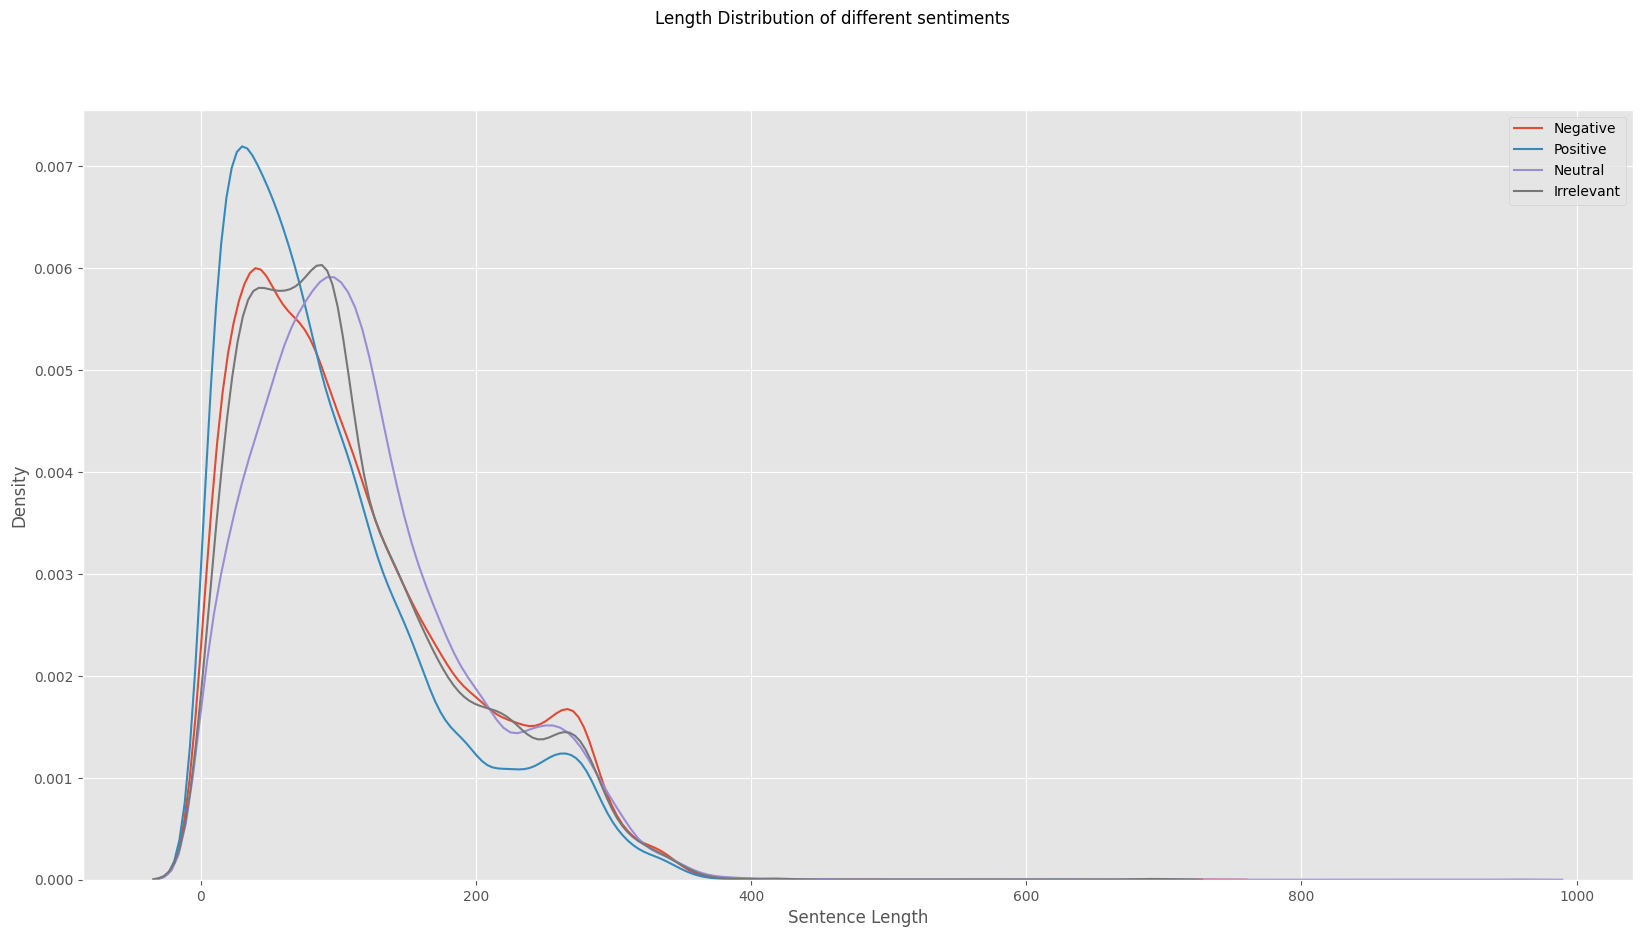

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure and axis object with a specific size
fig, ax = plt.subplots(figsize=(20, 10))

# Set the main title for the entire figure
fig.suptitle('Length Distribution of different sentiments')

# Plot the distribution of sentence lengths for each sentiment category using seaborn's distplot
sns.distplot(df[df['Sentiment'] == 'Negative']['Length'], label='Negative', hist=False)
sns.distplot(df[df['Sentiment'] == 'Positive']['Length'], label='Positive', hist=False)
sns.distplot(df[df['Sentiment'] == 'Neutral']['Length'], label='Neutral', hist=False)
sns.distplot(df[df['Sentiment'] == 'Irrelevant']['Length'], label='Irrelevant', hist=False)

# Set the x-axis label
ax.set_xlabel('Sentence Length')

# Display a legend indicating the different sentiment categories
ax.legend()

# Show the plot
plt.show()


<ipython-input-21-8ac796c2abed>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['Sentiment'] == 'Negative']['No_of_Words'], label='Negative', hist=False)
<ipython-input-21-8ac796c2abed>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['Sentiment'] == 'Positive'][

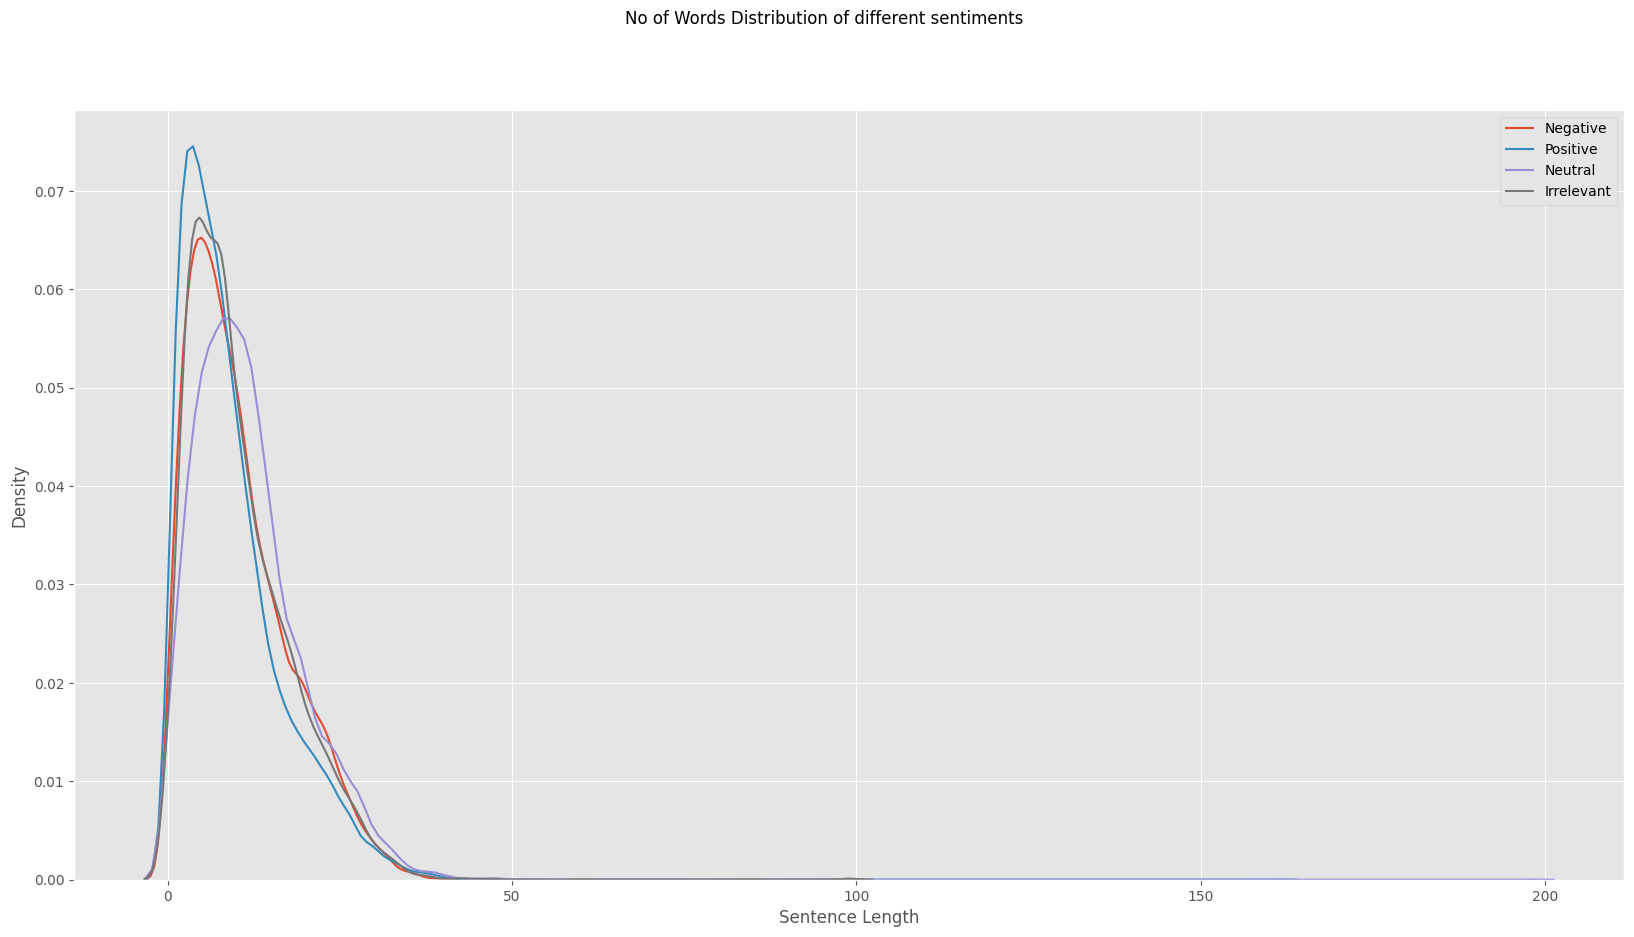

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure and axis object with a specific size
fig, ax = plt.subplots(figsize=(20, 10))

# Set the main title for the entire figure
fig.suptitle('No of Words Distribution of different sentiments')

# Plot the distribution of sentence lengths for each sentiment category using seaborn's distplot
sns.distplot(df[df['Sentiment'] == 'Negative']['No_of_Words'], label='Negative', hist=False)
sns.distplot(df[df['Sentiment'] == 'Positive']['No_of_Words'], label='Positive', hist=False)
sns.distplot(df[df['Sentiment'] == 'Neutral']['No_of_Words'], label='Neutral', hist=False)
sns.distplot(df[df['Sentiment'] == 'Irrelevant']['No_of_Words'], label='Irrelevant', hist=False)

# Set the x-axis label
ax.set_xlabel('Sentence Length')

# Display a legend indicating the different sentiment categories
ax.legend()

# Show the plot
plt.show()


<ipython-input-22-ed859aa8ba77>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['Sentiment'] == 'Negative']['No_of_Sentences'], label='Negative', hist=False)
<ipython-input-22-ed859aa8ba77>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['Sentiment'] == 'Positiv

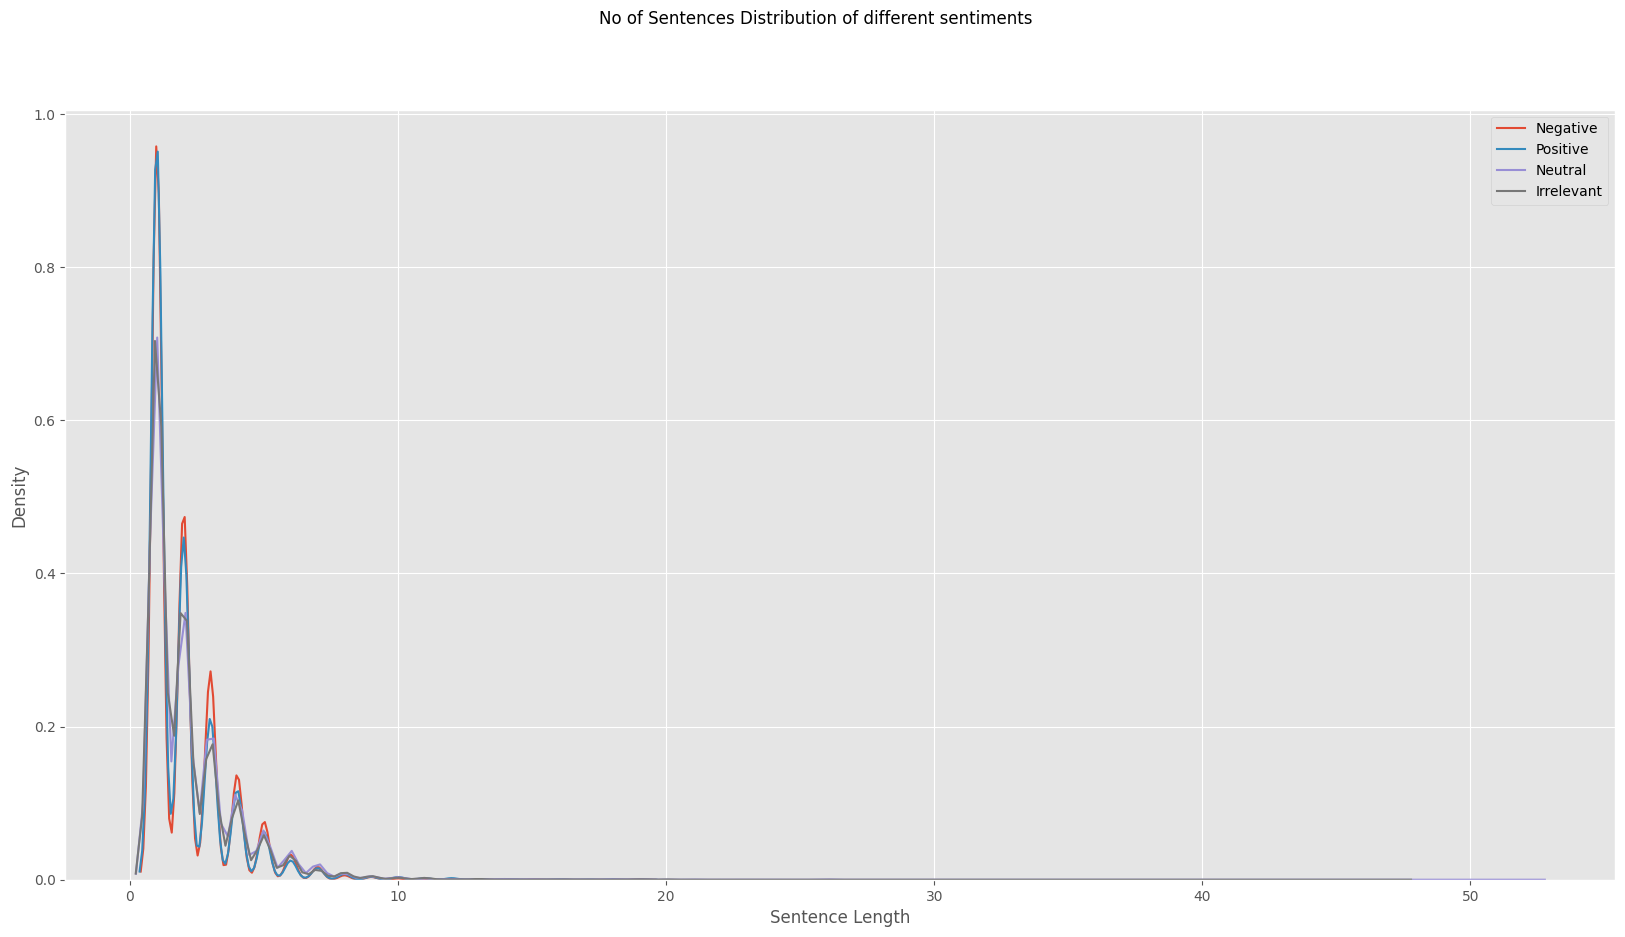

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure and axis object with a specific size
fig, ax = plt.subplots(figsize=(20, 10))

# Set the main title for the entire figure
fig.suptitle('No of Sentences Distribution of different sentiments')

# Plot the distribution of sentence lengths for each sentiment category using seaborn's distplot
sns.distplot(df[df['Sentiment'] == 'Negative']['No_of_Sentences'], label='Negative', hist=False)
sns.distplot(df[df['Sentiment'] == 'Positive']['No_of_Sentences'], label='Positive', hist=False)
sns.distplot(df[df['Sentiment'] == 'Neutral']['No_of_Sentences'], label='Neutral', hist=False)
sns.distplot(df[df['Sentiment'] == 'Irrelevant']['No_of_Sentences'], label='Irrelevant', hist=False)

# Set the x-axis label
ax.set_xlabel('Sentence Length')

# Display a legend indicating the different sentiment categories
ax.legend()

# Show the plot
plt.show()


# QUESTIONS

1. **Check for Relations between Sentiment and Topic:**
   - Investigate if there's any correlation or association between sentiment (positive/negative) and topics in the tweets.

2. **Utilizing Named Entities to Refine Topic Categories:**
   - Explore the potential of using named entities to refine or reduce the categories within topics and analyze if any patterns emerge based on this refined categorization.

3. **Analysis of Top Occurring Stopwords:**
   - Conduct an examination of the most frequent stopwords encountered within the text data and assess their significance or patterns in the context of the topics or sentiments.


## Analysis Plan: Positive and Negative Sentiments in Tweets based on Topics

### Objective:
To investigate relationships between sentiment (positive and negative) in tweets across different topics and various attributes of the text data.

#### Questions to Explore:

1. **Relation between Negative Sentiments and Topics with Sentence Length:**
   - Analyze if there's a correlation between negative tweets related to specific topics and the average length of sentences.
   
2. **Relation between Positive Sentiments and Topics with Sentence Length:**
   - Explore whether positive tweets associated with different topics correlate with the average sentence length.

3. **Negative Sentiments, Topics, and Average Word Count in a Sentence:**
   - Investigate the connection between negative tweets based on topics and the average number of words in a sentence.

4. **Positive Sentiments, Topics, and Average Word Count in a Sentence:**
   - Determine if there's an association between positive tweets concerning topics and the average number of words in a sentence.

5. **Negative Sentiments, Topics, and Average Number of Sentences:**
   - Examine if negative tweets linked to topics have a relationship with the average number of sentences.

6. **Positive Sentiments, Topics, and Average Number of Sentences:**
   - Assess whether positive tweets categorized by topics show a connection with the average number of sentences.

### Methodology:

1. **Data Preparation:**
   - Extract tweets categorized by topics and sentiment labels.
   - Calculate the average length of sentences, average word count in sentences, and the average number of sentences per tweet for each category
   
3. **Visualization:**
   - Create visualizations (scatter plots, bar charts, etc.) to illustrate any observed relationships.


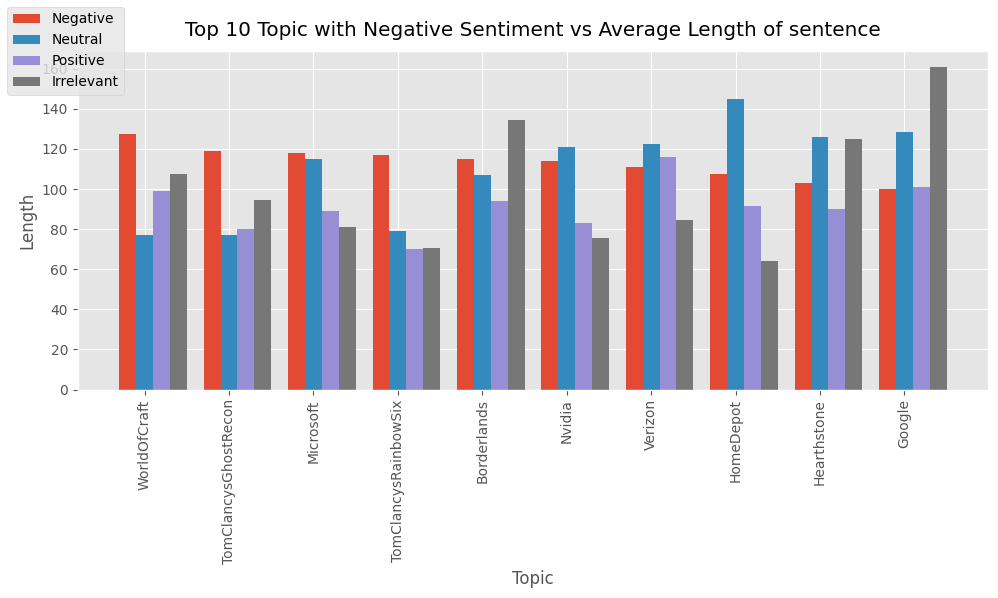

In [ ]:
# if there's a correlation between negative tweets related to specific topics and the average length of sentences.

top_five_negative_tweets = df.pivot_table(values='Length', index='Topic', columns='Sentiment', aggfunc='median').sort_values(by=['Negative'], ascending=[False]).iloc[:10,:]

# Plotting using Matplotlib
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.20
index = range(len(top_five_negative_tweets.index))

bar1 = ax.bar(index, top_five_negative_tweets['Negative'], bar_width, label='Negative')
bar2 = ax.bar([i + bar_width for i in index], top_five_negative_tweets['Neutral'], bar_width, label='Neutral')
bar3 = ax.bar([i + 2 * bar_width for i in index], top_five_negative_tweets['Positive'], bar_width, label='Positive')
bar3 = ax.bar([i + 3 * bar_width for i in index], top_five_negative_tweets['Irrelevant'], bar_width, label='Irrelevant')

ax.set_xlabel('Topic')
ax.set_ylabel('Length')
ax.set_title('Top 10 Topic with Negative Sentiment vs Average Length of sentence',y=1.02)
ax.set_xticks([i + bar_width for i in index])
ax.set_xticklabels(top_five_negative_tweets.index)
fig.legend(loc='upper left')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

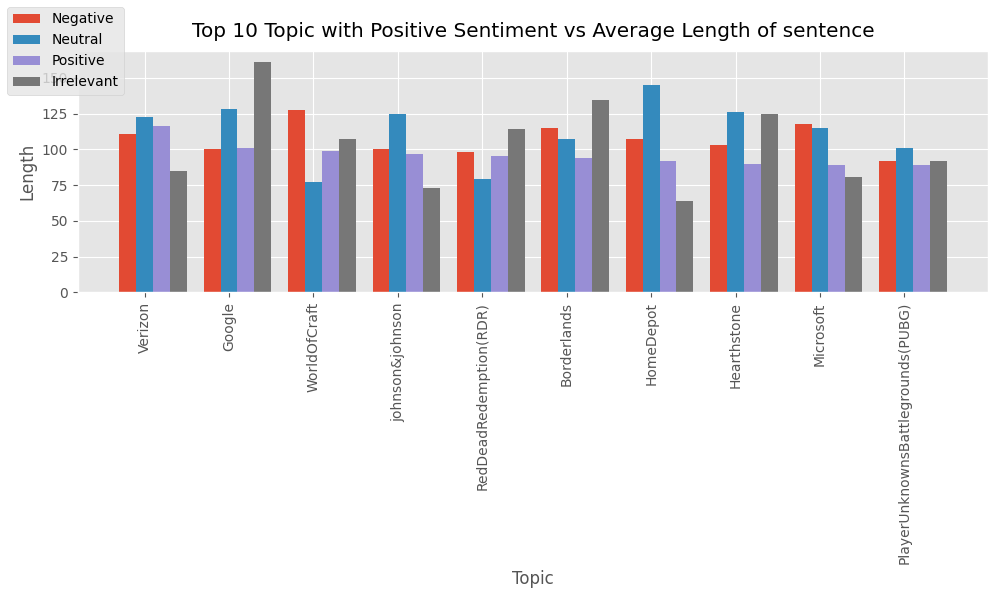

In [ ]:
# Explore whether positive tweets associated with different topics correlate with the average sentence length

top_five_negative_tweets = df.pivot_table(values='Length', index='Topic', columns='Sentiment', aggfunc='median').sort_values(by=['Positive'], ascending=[False]).iloc[:10,:]

# Plotting using Matplotlib
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.20
index = range(len(top_five_negative_tweets.index))

bar1 = ax.bar(index, top_five_negative_tweets['Negative'], bar_width, label='Negative')
bar2 = ax.bar([i + bar_width for i in index], top_five_negative_tweets['Neutral'], bar_width, label='Neutral')
bar3 = ax.bar([i + 2 * bar_width for i in index], top_five_negative_tweets['Positive'], bar_width, label='Positive')
bar3 = ax.bar([i + 3 * bar_width for i in index], top_five_negative_tweets['Irrelevant'], bar_width, label='Irrelevant')

ax.set_xlabel('Topic')
ax.set_ylabel('Length')
ax.set_title('Top 10 Topic with Positive Sentiment vs Average Length of sentence',y=1.02)
ax.set_xticks([i + bar_width for i in index])
ax.set_xticklabels(top_five_negative_tweets.index)
fig.legend(loc='upper left')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

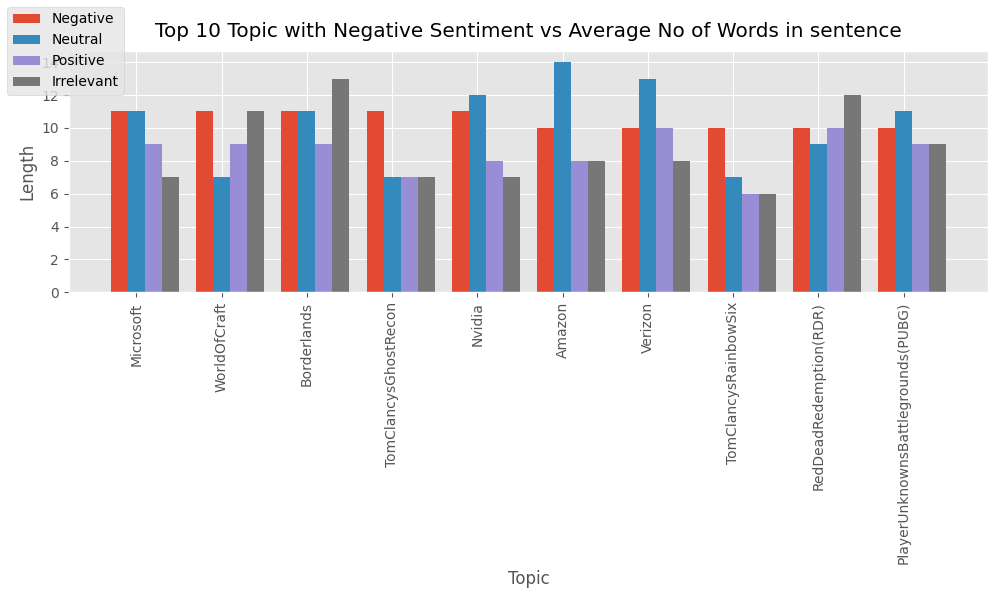

In [ ]:
# Investigate the connection between negative tweets based on topics and the average number of words in a sentence.

top_five_negative_tweets = df.pivot_table(values='No_of_Words', index='Topic', columns='Sentiment', aggfunc='median').sort_values(by=['Negative'], ascending=[False]).iloc[:10,:]

# Plotting using Matplotlib
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.20
index = range(len(top_five_negative_tweets.index))

bar1 = ax.bar(index, top_five_negative_tweets['Negative'], bar_width, label='Negative')
bar2 = ax.bar([i + bar_width for i in index], top_five_negative_tweets['Neutral'], bar_width, label='Neutral')
bar3 = ax.bar([i + 2 * bar_width for i in index], top_five_negative_tweets['Positive'], bar_width, label='Positive')
bar3 = ax.bar([i + 3 * bar_width for i in index], top_five_negative_tweets['Irrelevant'], bar_width, label='Irrelevant')

ax.set_xlabel('Topic')
ax.set_ylabel('Length')
ax.set_title('Top 10 Topic with Negative Sentiment vs Average No of Words in sentence',y=1.02)
ax.set_xticks([i + bar_width for i in index])
ax.set_xticklabels(top_five_negative_tweets.index)
fig.legend(loc='upper left')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

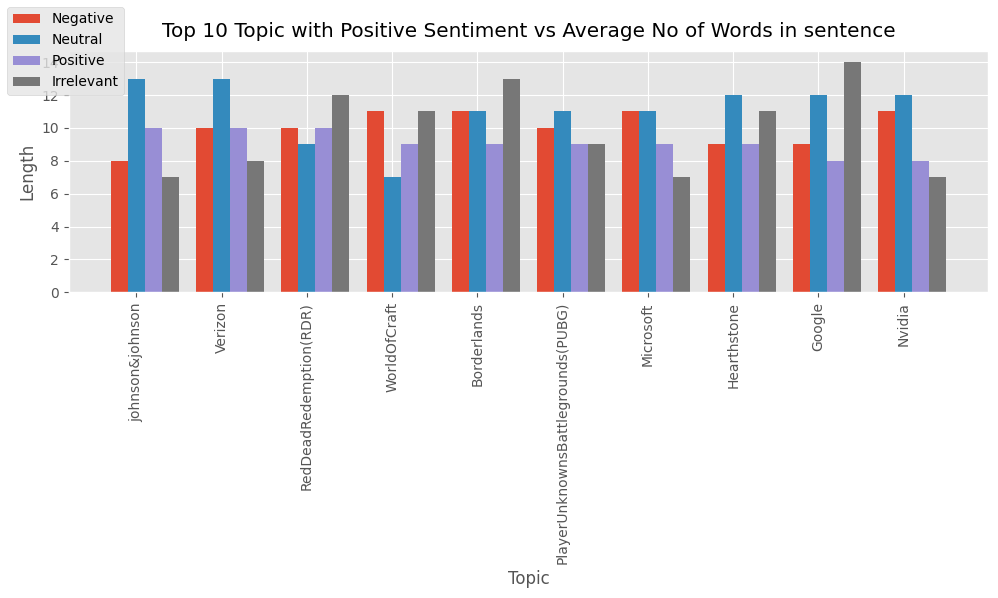

In [ ]:
# Determine if there's an association between positive tweets concerning topics and the average number of words in a sentence.

top_five_negative_tweets = df.pivot_table(values='No_of_Words', index='Topic', columns='Sentiment', aggfunc='median').sort_values(by=['Positive'], ascending=[False]).iloc[:10,:]

# Plotting using Matplotlib
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.20
index = range(len(top_five_negative_tweets.index))

bar1 = ax.bar(index, top_five_negative_tweets['Negative'], bar_width, label='Negative')
bar2 = ax.bar([i + bar_width for i in index], top_five_negative_tweets['Neutral'], bar_width, label='Neutral')
bar3 = ax.bar([i + 2 * bar_width for i in index], top_five_negative_tweets['Positive'], bar_width, label='Positive')
bar3 = ax.bar([i + 3 * bar_width for i in index], top_five_negative_tweets['Irrelevant'], bar_width, label='Irrelevant')

ax.set_xlabel('Topic')
ax.set_ylabel('Length')
ax.set_title('Top 10 Topic with Positive Sentiment vs Average No of Words in sentence',y=1.02)
ax.set_xticks([i + bar_width for i in index])
ax.set_xticklabels(top_five_negative_tweets.index)
fig.legend(loc='upper left')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

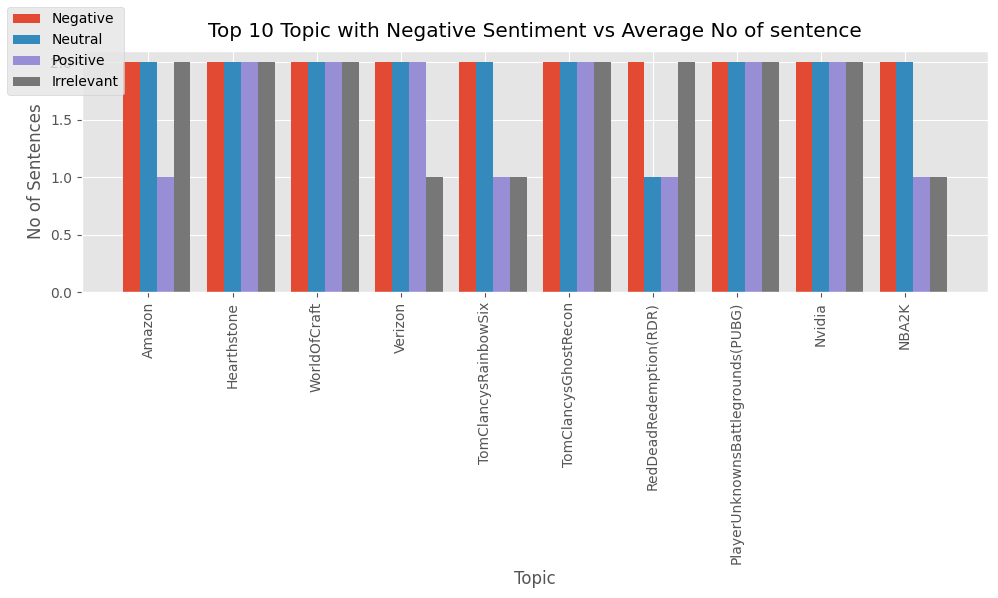

In [ ]:
# Examine if negative tweets linked to topics have a relationship with the average number of sentences.

top_five_negative_tweets = df.pivot_table(values='No_of_Sentences', index='Topic', columns='Sentiment', aggfunc='median').sort_values(by=['Negative'], ascending=[False]).iloc[:10,:]

# Plotting using Matplotlib
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.20
index = range(len(top_five_negative_tweets.index))

bar1 = ax.bar(index, top_five_negative_tweets['Negative'], bar_width, label='Negative')
bar2 = ax.bar([i + bar_width for i in index], top_five_negative_tweets['Neutral'], bar_width, label='Neutral')
bar3 = ax.bar([i + 2 * bar_width for i in index], top_five_negative_tweets['Positive'], bar_width, label='Positive')
bar3 = ax.bar([i + 3 * bar_width for i in index], top_five_negative_tweets['Irrelevant'], bar_width, label='Irrelevant')

ax.set_xlabel('Topic')
ax.set_ylabel('No of Sentences')
ax.set_title('Top 10 Topic with Negative Sentiment vs Average No of sentence',y=1.02)
ax.set_xticks([i + bar_width for i in index])
ax.set_xticklabels(top_five_negative_tweets.index)
fig.legend(loc='upper left')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

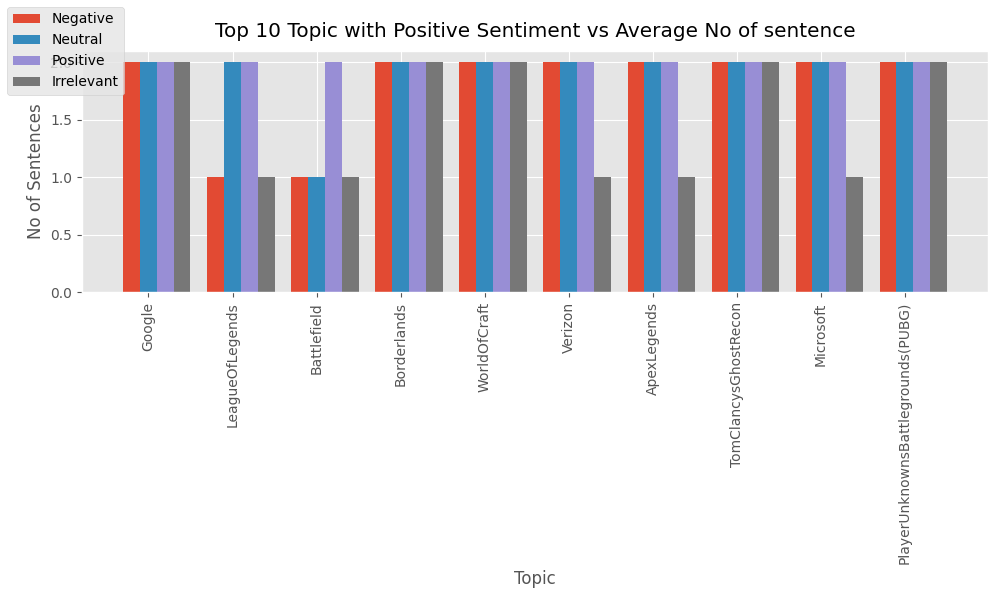

In [ ]:
# whether positive tweets categorized by topics show a connection with the average number of sentences.

top_five_negative_tweets = df.pivot_table(values='No_of_Sentences', index='Topic', columns='Sentiment', aggfunc='median').sort_values(by=['Positive'], ascending=[False]).iloc[:10,:]

# Plotting using Matplotlib
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.20
index = range(len(top_five_negative_tweets.index))

bar1 = ax.bar(index, top_five_negative_tweets['Negative'], bar_width, label='Negative')
bar2 = ax.bar([i + bar_width for i in index], top_five_negative_tweets['Neutral'], bar_width, label='Neutral')
bar3 = ax.bar([i + 2 * bar_width for i in index], top_five_negative_tweets['Positive'], bar_width, label='Positive')
bar3 = ax.bar([i + 3 * bar_width for i in index], top_five_negative_tweets['Irrelevant'], bar_width, label='Irrelevant')

ax.set_xlabel('Topic')
ax.set_ylabel('No of Sentences')
ax.set_title('Top 10 Topic with Positive Sentiment vs Average No of sentence',y=1.02)
ax.set_xticks([i + bar_width for i in index])
ax.set_xticklabels(top_five_negative_tweets.index)
fig.legend(loc='upper left')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Observations from Visualizations:

1. **Using Length of Sentence:**
   - There is a noticeable indication that the field 'Length' (average sentence length) might contribute to predicting sentiment, encompassing different topics.

2. **Using Length of Sentence:**
   - There is a slight indication that the field 'No of Words' (average number of words) could play a role in predicting sentiment across various topics.

3. **Using Length of Sentence:**
   - Contrarily, there seems to be no significant indication that the field 'No of Sentences' (average number of sentences) contributes to predicting sentiment among different topics.


<ipython-input-162-e3d809e9bc7e>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(transformed_data, label='Negative', hist=False)
<ipython-input-162-e3d809e9bc7e>:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(transformed_data, label='Positive', hist=False)
<ipython-input-1

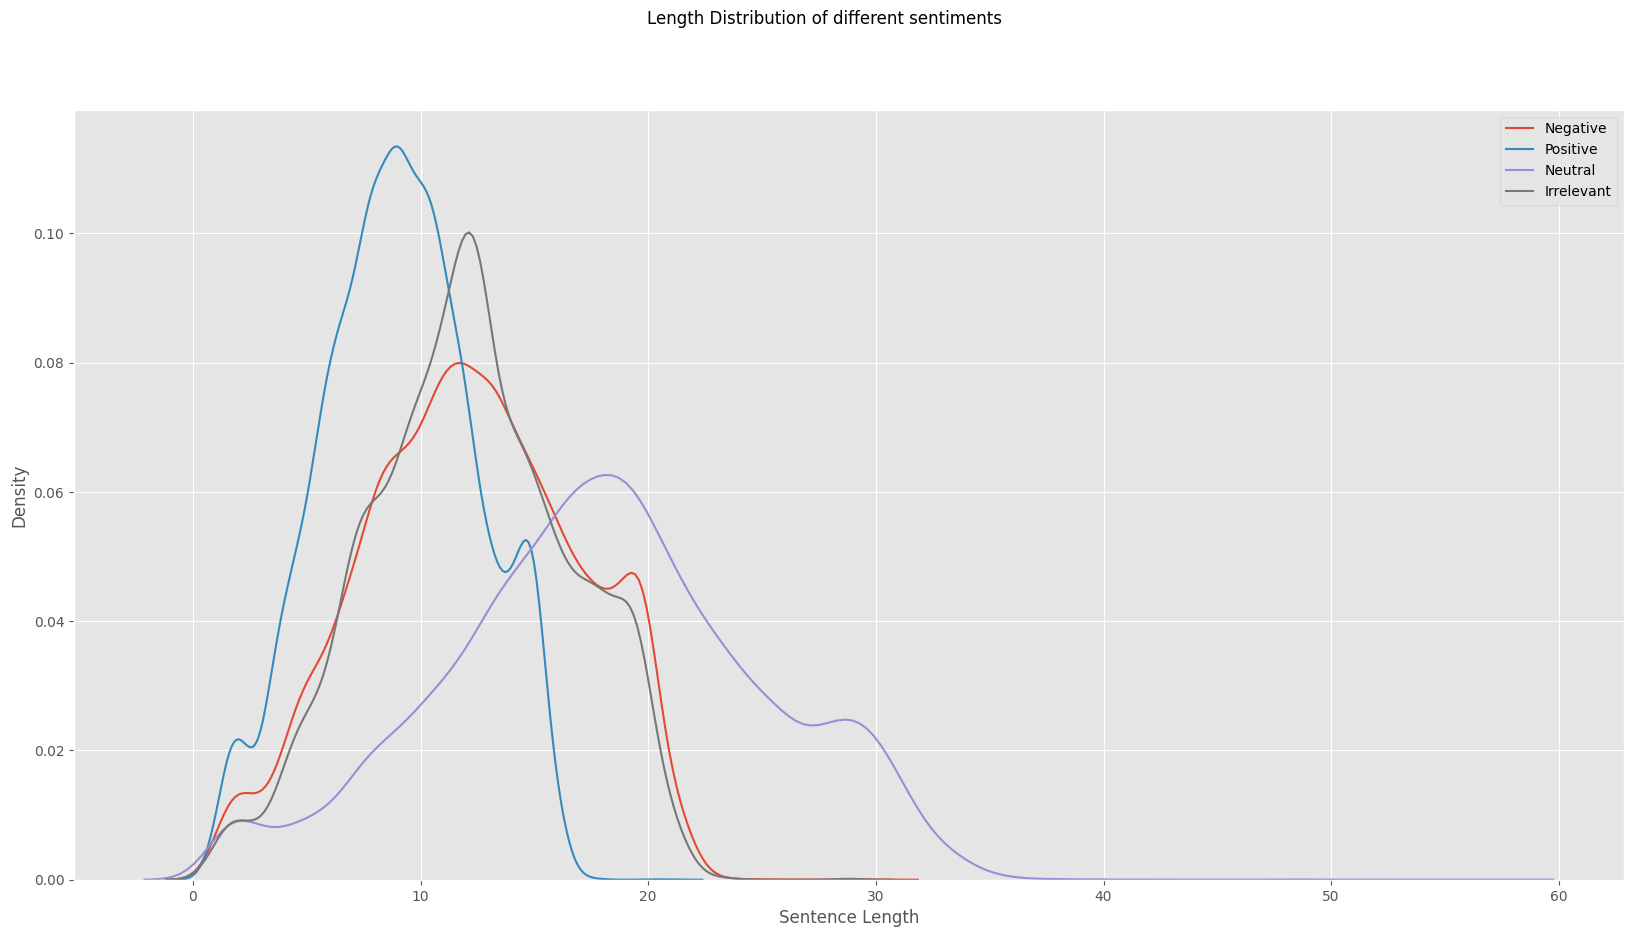

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure and axis object with a specific size
fig, ax = plt.subplots(figsize=(20, 10))

# Set the main title for the entire figure
fig.suptitle('Length Distribution of different sentiments')

# Plot the distribution of sentence lengths for each sentiment category using seaborn's distplot
transformed_data, lambda_value = stats.yeojohnson(df[df['Sentiment'] == 'Negative']['Length'])
sns.distplot(transformed_data, label='Negative', hist=False)

transformed_data, lambda_value = stats.yeojohnson(df[df['Sentiment'] == 'Positive']['Length'])
sns.distplot(transformed_data, label='Positive', hist=False)

transformed_data, lambda_value = stats.yeojohnson(df[df['Sentiment'] == 'Neutral']['Length'])
sns.distplot(transformed_data, label='Neutral', hist=False)

transformed_data, lambda_value = stats.yeojohnson(df[df['Sentiment'] == 'Irrelevant']['Length'])
sns.distplot(transformed_data, label='Irrelevant', hist=False)

# Set the x-axis label
ax.set_xlabel('Sentence Length')

# Display a legend indicating the different sentiment categories
ax.legend()

# Show the plot
plt.show()


<ipython-input-174-a3e995dc3930>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(transformed_data, hist=False)


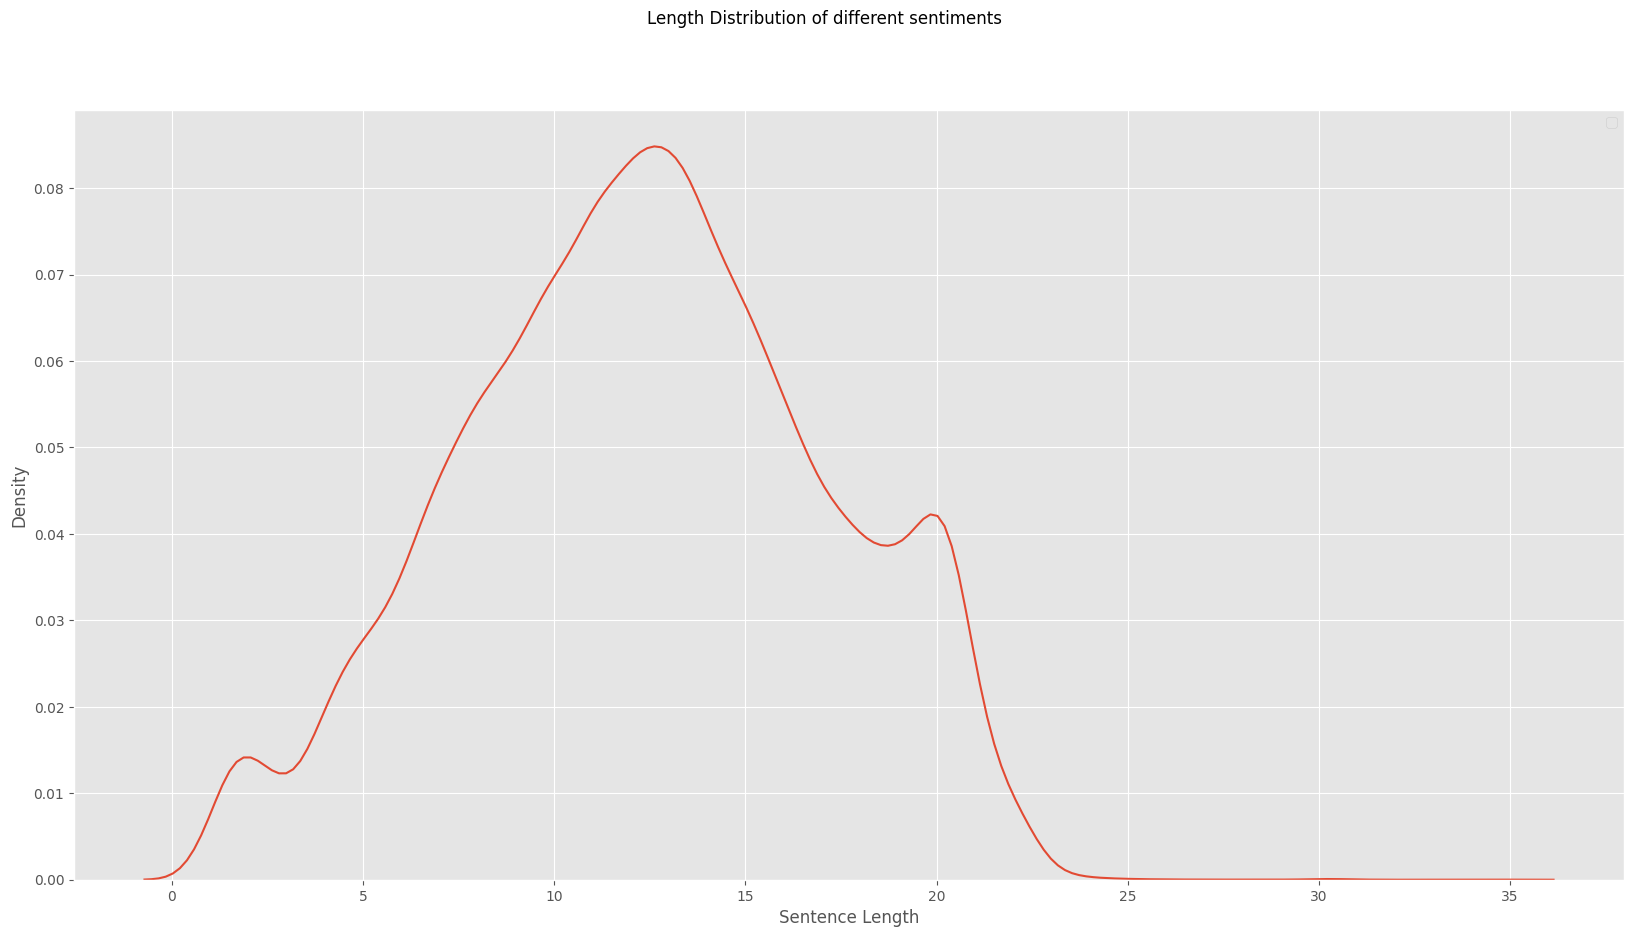

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure and axis object with a specific size
fig, ax = plt.subplots(figsize=(20, 10))

# Set the main title for the entire figure
fig.suptitle('Length Distribution of different sentiments')

# Plot the distribution of sentence lengths for each sentiment category using seaborn's distplot
transformed_data, lambda_value = stats.yeojohnson(df['Length'])
sns.distplot(transformed_data, hist=False)

# Set the x-axis label
ax.set_xlabel('Sentence Length')

# Display a legend indicating the different sentiment categories
ax.legend()

# Show the plot
plt.show()


<ipython-input-176-54a87878f191>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(transformed_data, label='Negative', hist=False)
<ipython-input-176-54a87878f191>:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(transformed_data, label='Positive', hist=False)
<ipython-input-1

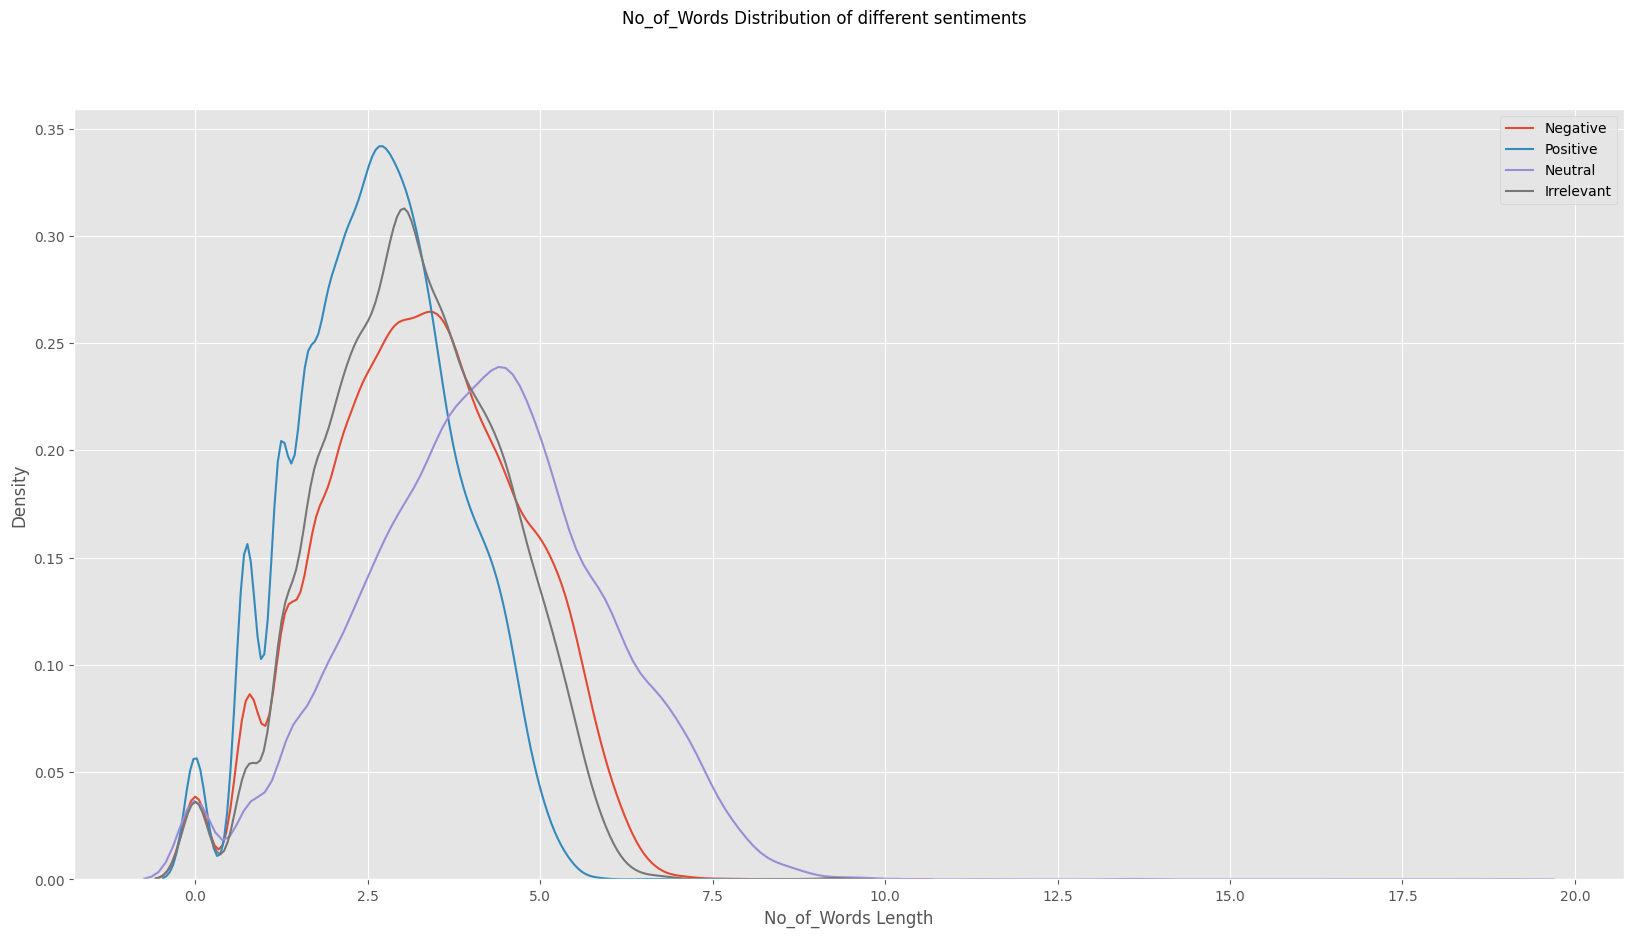

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure and axis object with a specific size
fig, ax = plt.subplots(figsize=(20, 10))

# Set the main title for the entire figure
fig.suptitle('No_of_Words Distribution of different sentiments')

# Plot the distribution of sentence lengths for each sentiment category using seaborn's distplot
transformed_data, lambda_value = stats.yeojohnson(df[df['Sentiment'] == 'Negative']['No_of_Words'])
sns.distplot(transformed_data, label='Negative', hist=False)

transformed_data, lambda_value = stats.yeojohnson(df[df['Sentiment'] == 'Positive']['No_of_Words'])
sns.distplot(transformed_data, label='Positive', hist=False)

transformed_data, lambda_value = stats.yeojohnson(df[df['Sentiment'] == 'Neutral']['No_of_Words'])
sns.distplot(transformed_data, label='Neutral', hist=False)

transformed_data, lambda_value = stats.yeojohnson(df[df['Sentiment'] == 'Irrelevant']['No_of_Words'])
sns.distplot(transformed_data, label='Irrelevant', hist=False)

# Set the x-axis label
ax.set_xlabel('No_of_Words Length')

# Display a legend indicating the different sentiment categories
ax.legend()

# Show the plot
plt.show()


<ipython-input-177-56fb9c691540>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(transformed_data, hist=False)


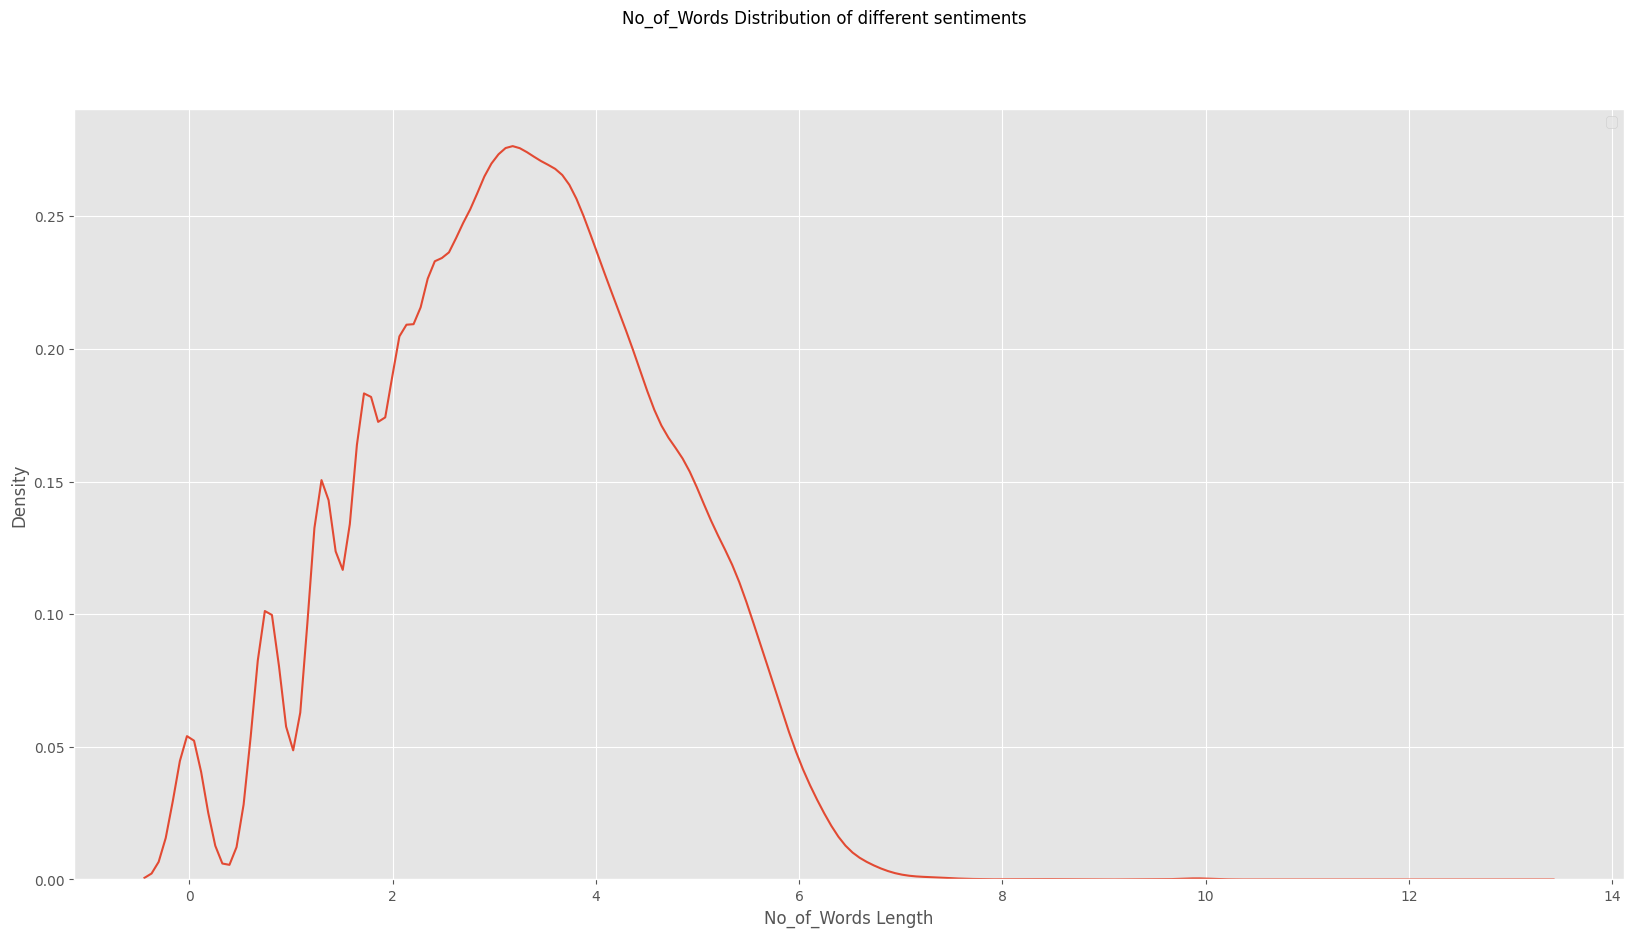

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure and axis object with a specific size
fig, ax = plt.subplots(figsize=(20, 10))

# Set the main title for the entire figure
fig.suptitle('No_of_Words Distribution of different sentiments')

# Plot the distribution of sentence lengths for each sentiment category using seaborn's distplot
transformed_data, lambda_value = stats.yeojohnson(df['No_of_Words'])
sns.distplot(transformed_data, hist=False)


# Set the x-axis label
ax.set_xlabel('No_of_Words Length')

# Display a legend indicating the different sentiment categories
ax.legend()

# Show the plot
plt.show()


# Yeo-Johnson Transformation Effects on Data Distribution

The Yeo-Johnson transformation is a powerful method often employed to approximate data distributions to a normal or Gaussian shape. However, despite its ability to bring the data closer to normality, it might not completely address issues such as outliers or skewed distributions.

### Specific Effects on Sentence Length and Word Quantity in Sentences

When applied to data representing sentence lengths and the number of words in a sentence, the Yeo-Johnson transformation tends to normalize the distribution to a certain extent. However, it's common to observe residual outliers and a skewed distribution towards the right.

### Skewed Distribution Characteristics

This skewness often indicates that a large quantity of sentences exhibit small lengths and fewer words per sentence, while a very small quantity of sentences have notably high lengths and a larger number of words per sentence.

### Robust Scaler as a Potential Solution

To handle such data that remains skewed even after transformation, employing a robust scaler could be beneficial. Robust scaling methods, like the RobustScaler in Scikit-learn, are resilient to outliers and skewed distributions. These scalers utilize statistics that are less influenced by outliers, enabling a better normalization of skewed data.

Later analysis or modeling could leverage robust scaling to preprocess the transformed data, ensuring that the skewed distributions do not unduly impact subsequent analyses.

Remember, the choice of preprocessing techniques, such as Yeo-Johnson transformation and robust scaling, should align with the characteristics of the data and the specific requirements of the analysis or modeling task.


In [ ]:
X,y = df['Content'],df['Sentiment']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [ ]:
pipe = Pipeline([
    ('TF_IDF',TfidfVectorizer(lowercase=True,stop_words=list(nlp.Defaults.stop_words))),
    ('MultinomialNB',MultinomialNB())
])

In [ ]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('TF_IDF', TfidfVectorizer(stop_words='english')),
                ('MultinomialNB', MultinomialNB())])

In [ ]:
X_train_prediction = pipe.predict(X_train)

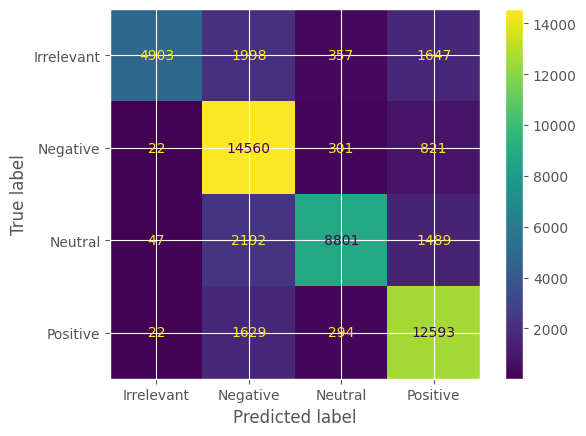

In [ ]:
cm = confusion_matrix(y_train,X_train_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=pipe['MultinomialNB'].classes_)
disp.plot()

In [ ]:
print(classification_report(y_train,X_train_prediction))

              precision    recall  f1-score   support

  Irrelevant       0.98      0.55      0.71      8905
    Negative       0.71      0.93      0.81     15704
     Neutral       0.90      0.70      0.79     12529
    Positive       0.76      0.87      0.81     14538

    accuracy                           0.79     51676
   macro avg       0.84      0.76      0.78     51676
weighted avg       0.82      0.79      0.79     51676



In [ ]:
balanced_accuracy_score(y_train,X_train_prediction)

0.7616012183947236

In [ ]:
X_test_prediction = pipe.predict(X_test)

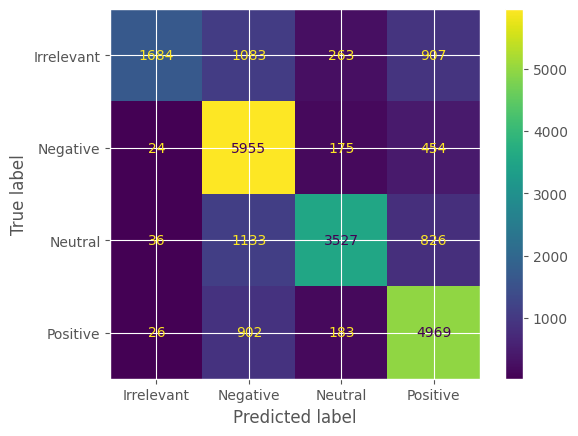

In [ ]:
cm = confusion_matrix(y_test,X_test_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=pipe['MultinomialNB'].classes_)
disp.plot()

In [ ]:
print(classification_report(y_test,X_test_prediction))

              precision    recall  f1-score   support

  Irrelevant       0.95      0.43      0.59      3937
    Negative       0.66      0.90      0.76      6608
     Neutral       0.85      0.64      0.73      5522
    Positive       0.69      0.82      0.75      6080

    accuracy                           0.73     22147
   macro avg       0.79      0.70      0.71     22147
weighted avg       0.77      0.73      0.72     22147



In [ ]:
balanced_accuracy_score(y_train,X_train_prediction),balanced_accuracy_score(y_test,X_test_prediction)

(0.7616012183947236, 0.6962262088935868)

In [ ]:
pipe = Pipeline([
    ('TF_IDF',TfidfVectorizer(lowercase=True,stop_words=list(nlp.Defaults.stop_words))),
    ('LogisticRegression',LogisticRegression(max_iter=1000))
])

In [ ]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('TF_IDF', TfidfVectorizer(stop_words='english')),
                ('LogisticRegression', LogisticRegression(max_iter=1000))])

In [ ]:
X_train_prediction = pipe.predict(X_train)

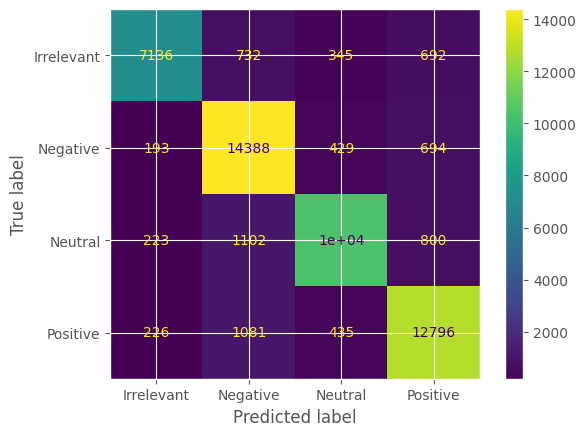

In [ ]:
cm = confusion_matrix(y_train,X_train_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=pipe['LogisticRegression'].classes_)
disp.plot()

In [ ]:
print(classification_report(y_train,X_train_prediction))

              precision    recall  f1-score   support

  Irrelevant       0.92      0.80      0.86      8905
    Negative       0.83      0.92      0.87     15704
     Neutral       0.90      0.83      0.86     12529
    Positive       0.85      0.88      0.87     14538

    accuracy                           0.87     51676
   macro avg       0.87      0.86      0.86     51676
weighted avg       0.87      0.87      0.87     51676



In [ ]:
X_test_prediction = pipe.predict(X_test)

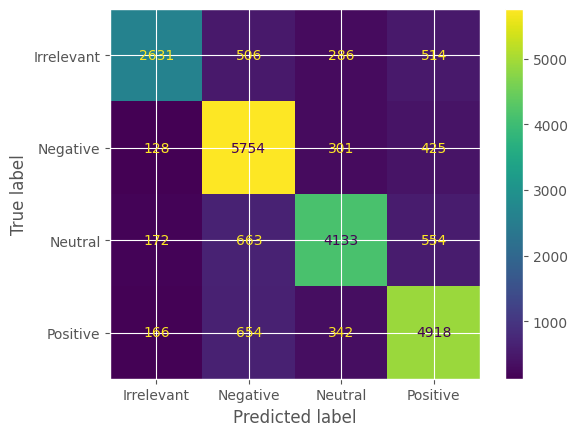

In [ ]:
cm = confusion_matrix(y_test,X_test_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=pipe['LogisticRegression'].classes_)
disp.plot()

In [ ]:
print(classification_report(y_test,X_test_prediction))

              precision    recall  f1-score   support

  Irrelevant       0.85      0.67      0.75      3937
    Negative       0.76      0.87      0.81      6608
     Neutral       0.82      0.75      0.78      5522
    Positive       0.77      0.81      0.79      6080

    accuracy                           0.79     22147
   macro avg       0.80      0.77      0.78     22147
weighted avg       0.79      0.79      0.79     22147



In [ ]:
balanced_accuracy_score(y_train,X_train_prediction),balanced_accuracy_score(y_test,X_test_prediction)

(0.8570292073133707, 0.7740950825016044)

In [ ]:
param_grid = {
    "LogisticRegression__penalty":['l1', 'l2', 'elasticnet'],
    "LogisticRegression__C": np.logspace(-4, 4, 10),
    'LogisticRegression__solver':['liblinear','saga'],
    'LogisticRegression__l1_ratio':np.linspace(0.1,1,10)
}

pipe = Pipeline([
    ('TF_IDF',TfidfVectorizer(lowercase=True,stop_words=list(nlp.Defaults.stop_words))),
    ('LogisticRegression',LogisticRegression(max_iter=1000))
])

In [ ]:
search = GridSearchCV(pipe, param_grid, n_jobs=2,cv=5)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)